In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from joblib import dump, load

In [2]:
#import xlsx file
df = pd.read_excel(r'data\processed.xlsx')
df.columns = df.iloc[0]
df = df.drop(df.index[0])
df = df.dropna()
df = df.rename(columns={df.columns[1]: 'Na2CO3(lt/hr)'})
df = df.rename(columns={df.columns[2]: 'NaOH(lt/hr)'})
df = df.rename(columns={df.columns[-2]: 'Filter_Ca'})
df = df.rename(columns={df.columns[-1]: 'Filter_Mg'})
df = df.drop(df.index[150:180])
df = df.drop(df[df['Filter_Ca']/df["Rich MEG flow(M3/hr)"] > 20].index)
df = df.drop(df[df['Filter_Mg']/df["Rich MEG flow(M3/hr)"] > 20].index)
df = df.drop(df[df['NaOH(lt/hr)']/df["Rich MEG flow(M3/hr)"] > 15].index)
df = df.drop(df[df['Na2CO3(lt/hr)']/df["Rich MEG flow(M3/hr)"] > 15].index)
df

,Rich MEG flow(M3/hr),Na2CO3(lt/hr),NaOH(lt/hr),Filter_Ca,Filter_Mg
2,8,85,25,0,0
3,9,105,25,45,0
5,9,102,25,0,0
7,8,83,25,0,0
8,8,85,25,69,0
...,...,...,...,...,...
994,24,161,22.2,67.74,55.548
1003,21,161,22.3,237.8,50.782
1012,21,151,21.3,68.4,34.274
1021,21,154.1,19.3,80.6,55.93


In [3]:
#divide df by first column
df = df.div(df.iloc[:,0], axis=0)

df = df.drop(df[df["Na2CO3(lt/hr)"] == 0].index)
df["NaOH(lt/hr)"].min()

0.5

Text(0, 0.5, 'Lt/hr & PPM')

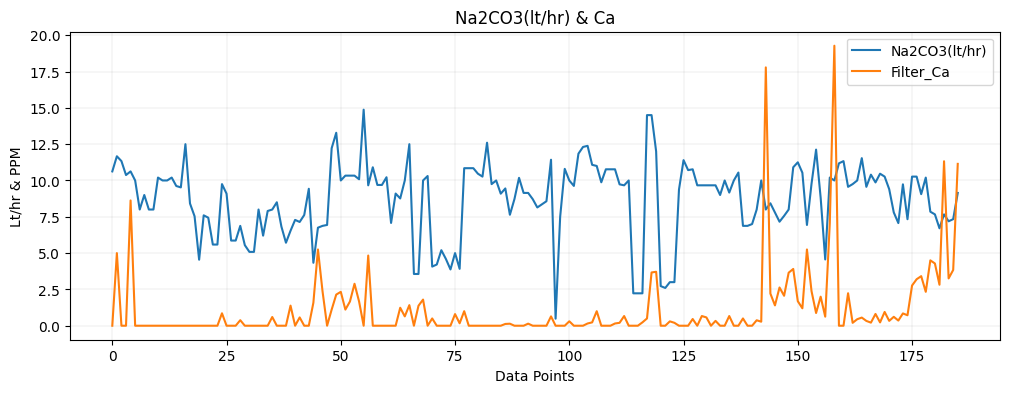

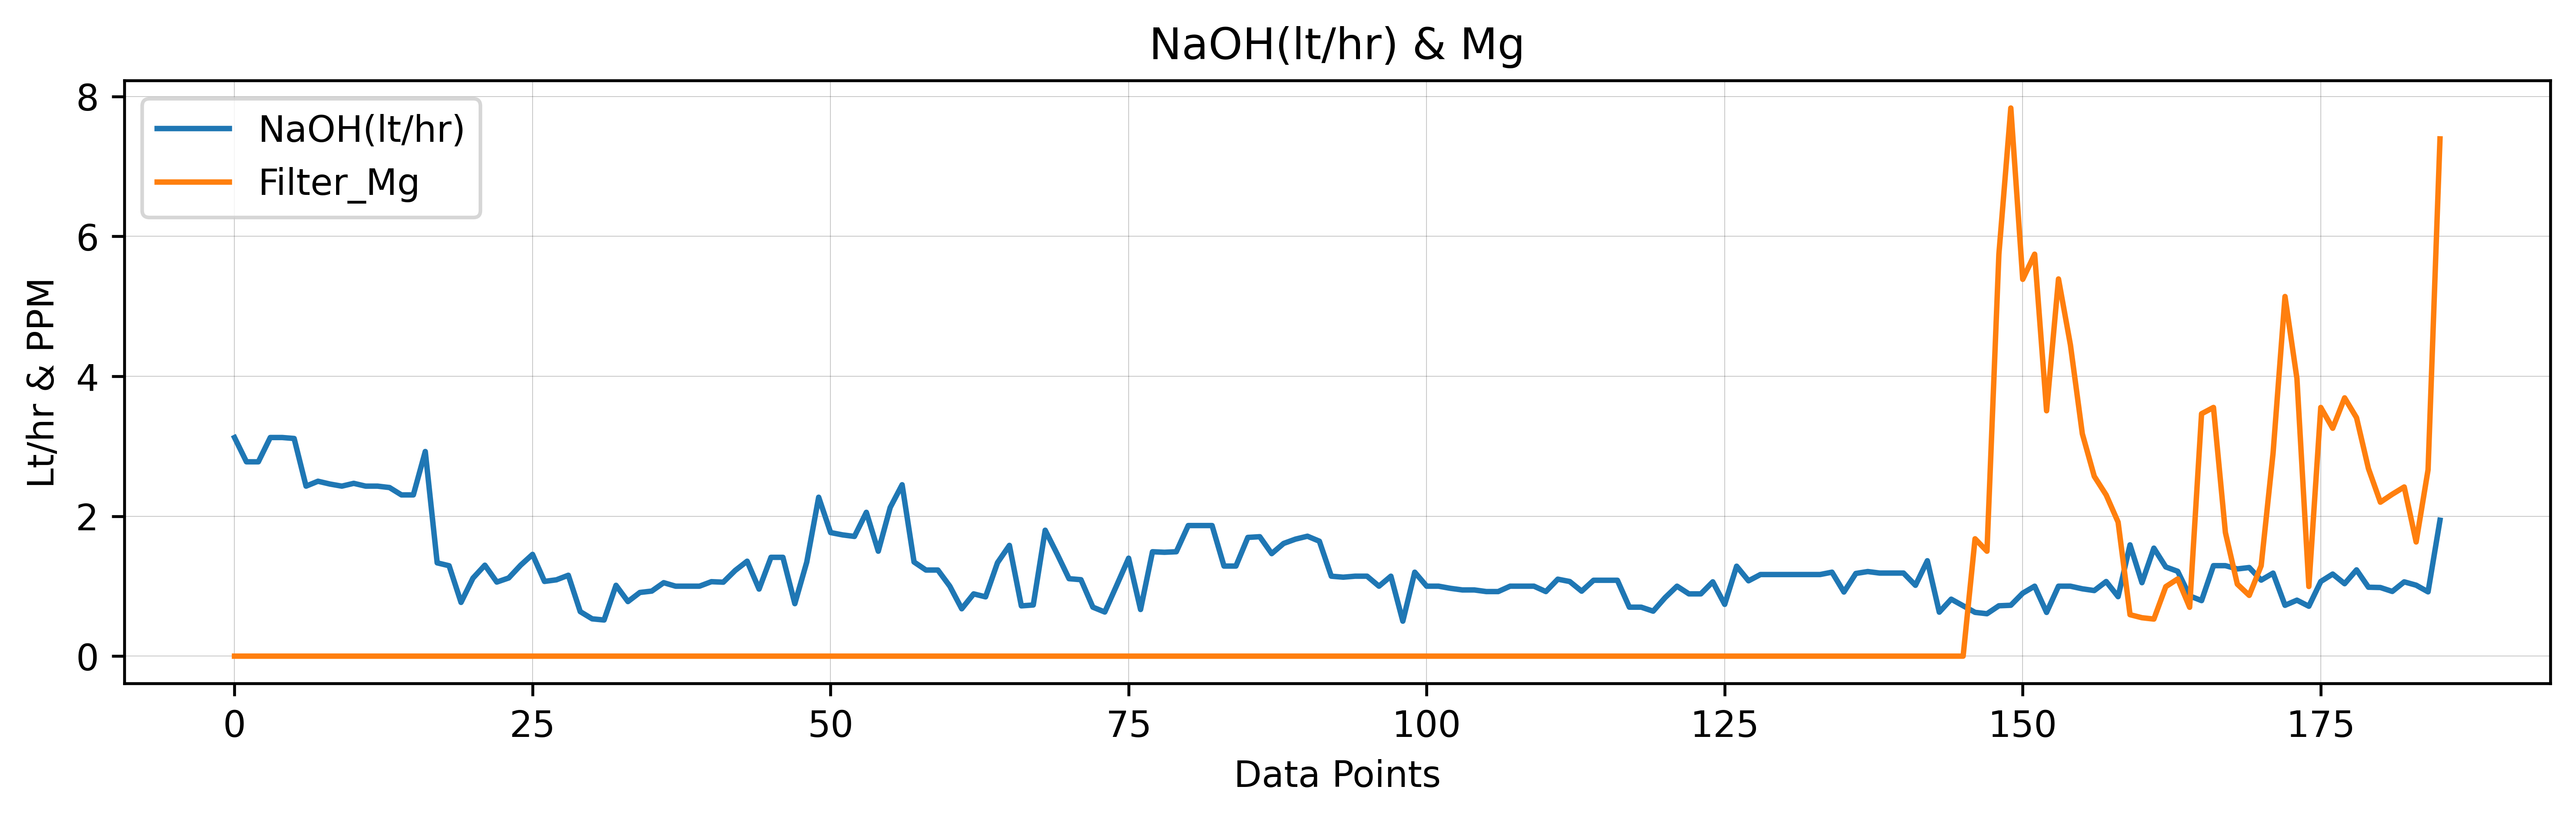

In [4]:
plt.figure(figsize=(12,4))
plt.rcParams['figure.dpi'] = 600
plt.grid(color='black', linestyle='-', linewidth=0.05)
plt.title('Na2CO3(lt/hr) & Ca')

plt.plot(range(0,len(df['Na2CO3(lt/hr)'])), df['Na2CO3(lt/hr)'], label='Na2CO3(lt/hr)')
plt.plot(range(0,len(df['Filter_Ca'])), df['Filter_Ca'], label='Filter_Ca')
plt.legend()
plt.xlabel('Data Points')
plt.ylabel('Lt/hr & PPM')

plt.figure(figsize=(12,3))
plt.rcParams['figure.dpi'] = 600
plt.grid(color='black', linestyle='-', linewidth=0.05)

plt.title('NaOH(lt/hr) & Mg')
plt.plot(range(0,len(df['NaOH(lt/hr)'])), df['NaOH(lt/hr)'],label='NaOH(lt/hr)')
plt.plot(range(0,len(df['Filter_Mg'])), df['Filter_Mg'],label='Filter_Mg')
plt.legend()
plt.xlabel('Data Points')
plt.ylabel('Lt/hr & PPM')

In [5]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from joblib import dump, load


import warnings
warnings.filterwarnings('ignore')


# Clear the console
os.system('cls' if os.name == 'nt' else 'clear')

sys.path.append(r'C:\Users\ovayi\OneDrive\Defterler\OneDrive\Projeler\SLB\DSV_Opt')

# Load model and converter
loaded_model_Ca = load(r'Calsium\CO3_Injection.joblib')
loaded_converter_Ca = load(r'Calsium\CO3_Injection_Converter.joblib')
loaded_model_Mg = load(r'Magnesium\OH_Injection.joblib')
loaded_converter_Mg = load(r'Magnesium\OH_Injection_Converter.joblib')

# Define the function
def get_CO3(rich_MEG_flow_m3_hr):
    Calcium = 0  
    loaded_data_Ca = np.array([[Calcium]])
    transformed_data_Ca = loaded_converter_Ca.transform(loaded_data_Ca)
    result_injection_Ca = loaded_model_Ca.predict(transformed_data_Ca)
    
    return result_injection_Ca[0] * rich_MEG_flow_m3_hr

def get_OH(rich_MEG_flow_m3_hr):
    Magnesium = 0
    loaded_data_Mg = np.array([[Magnesium]])
    transformed_data_Mg = loaded_converter_Mg.transform(loaded_data_Mg)
    result_injection_Mg = loaded_model_Mg.predict(transformed_data_Mg)
    
    return result_injection_Mg[0] * rich_MEG_flow_m3_hr

In [11]:
rich_MEG_flow_m3_hr = np.arange(5, 55, 1)

get_CO3(rich_MEG_flow_m3_hr)
get_OH(rich_MEG_flow_m3_hr)



CO3_Inj = get_CO3(rich_MEG_flow_m3_hr)
OH_Inj = get_OH(rich_MEG_flow_m3_hr)

#create dataframe
injections = pd.DataFrame({'Rich MEG flow(M3/hr)': rich_MEG_flow_m3_hr, 'CO3 Injection (lt/hr)': CO3_Inj, 'OH Injection (lt/hr)': OH_Inj})

injections = injections.set_index('Rich MEG flow(M3/hr)')

In [21]:
co3 = 0.8 #molar
oh = 0.8 #molar

injections["Ca(CO3)2 kg/hr"] = (((injections["CO3 Injection (lt/hr)"]) * co3/2)* 100.0869 * 24) / 1000
injections["Mg(OH)2 kg/hr"] = ((injections["OH Injection (lt/hr)"] * oh/2)* 58.3197* 24 ) / 1000
display(injections)

,CO3 Injection (lt/hr),OH Injection (lt/hr),Ca(CO3)2 kg/hr,Mg(OH)2 kg/hr
Rich MEG flow(M3/hr),,,,
5,43.771784,6.642288,42.057429,3.718812
6,52.526141,7.970746,50.468915,4.462575
7,61.280498,9.299204,58.880401,5.206337
8,70.034855,10.627661,67.291887,5.950099
9,78.789212,11.956119,75.703373,6.693862
10,87.543569,13.284577,84.114859,7.437624
11,96.297926,14.613034,92.526344,8.181387
12,105.052283,15.941492,100.937830,8.925149
13,113.806640,17.269949,109.349316,9.668911
